<a href="https://colab.research.google.com/github/massivetexts/motes-corpus/blob/master/analysis/MOTESCorpusBiasAnalysisAndComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!git clone https://github.com/massivetexts/open-scoring
!cd open-scoring && python setup.py develop
!pip install wefe

In [ ]:
#@markdown ### Imports
#@markdown After installing libraries above, you may need to restart runtime (Ctrl+M, then . ) to continue.
#!pip install -q git+git://github.com/massivetexts/open-scoring
#!pip install -q git+git://github.com/massivetexts/motes-corpus
import open_scoring as ocs
from gensim.models import KeyedVectors
import gensim.downloader as api
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
#import motes_corpus as motes

In [ ]:
#@title Download MOTES and Enwiki Models and Initiate Scorer
scorer = ocs.scoring.AUT_Scorer()

print('Downloading MOTES (100k)')
if not os.path.exists('all_weighted_10-12_100k.kv.vectors.npy'):
    !wget https://openscoring.du.edu/data/all_weighted_10-12_100k.kv
    !wget https://openscoring.du.edu/data/all_weighted_10-12_100k.kv.vectors.npy
motes_model = KeyedVectors.load('./all_weighted_10-12_100k.kv')
scorer._models['motes'] = motes_model

print('Downloading Enwiki')
if not os.path.exists('enwiki_full_100k.kv.vectors.npy'):
    !wget https://openscoring.du.edu/data/enwiki_full_100k.kv
    !wget https://openscoring.du.edu/data/enwiki_full_100k.kv.vectors.npy
enmodel = KeyedVectors.load('./enwiki_full_100k.kv')
scorer._models['baseline'] = enmodel

print('Downloading GloVe')
scorer._models['glove'] = api.load("glove-wiki-gigaword-300")

In [ ]:
# optionally load other models. These need to be uploaded to colab, since
# they exist on a firewalled server
from pathlib import Path
models = list(Path('.').glob('*kv'))
for modelpath in models:
    scorer._models[modelpath.stem] = KeyedVectors.load(str(modelpath))

In [ ]:
# truncate GloVe to match vocabulary of other models
from gensim.models import KeyedVectors
from collections import OrderedDict
import gensim

def truncate_keyedvectors(kv, include_list):
    ''' Truncate a KeyedVectors word embedding model to a given vocabulary'''
    new_vocab = OrderedDict()
    include_dims = []
    for i, word in enumerate(include_list):
        vocab_item = gensim.models.keyedvectors.Vocab()
        include_dims.append(kv.vocab[word].index)
        vocab_item.index = i
        new_vocab[word] = vocab_item
    new_kv = gensim.models.keyedvectors.KeyedVectors(len(new_vocab))
    new_kv.vocab = new_vocab
    new_kv.index2word = list(new_vocab.keys())
    new_kv.vectors = kv.vectors[include_dims]
    return new_kv

vocab_include_list = list(scorer._models['baseline'].vocab.keys())
scorer._models['glove'] = truncate_keyedvectors(scorer._models['glove'], vocab_include_list)
len(scorer._models['glove'].vocab)

100000

# Bias Analysis

For this use the WEFE library.
- https://github.com/dccuchile/wefe
- https://www.kdnuggets.com/2020/08/word-embedding-fairness-evaluation.html
- paper: https://felipebravom.com/publications/ijcai2020.pdf


In [ ]:
from wefe import WordEmbeddingModel, Query, WEAT, load_weat
from wefe.utils import run_queries, plot_queries_results

In [ ]:
#@markdown Load the WEAT wordset
weat_wordset = load_weat()

# WEAT 1: Flowers vs Insects wrt Pleasant and Unpleasant
weat_1 = Query([weat_wordset['flowers'], weat_wordset['insects']],
          [weat_wordset['pleasant_5'], weat_wordset['unpleasant_5']],
          ['Flowers', 'Insects'], ['Pleasant(5)', 'Unpleasant(5)'])

# WEAT 2: Instruments vs Weapons wrt Pleasant and Unpleasant
weat_2 = Query([weat_wordset['instruments'], weat_wordset['weapons']],
          [weat_wordset['pleasant_5'], weat_wordset['unpleasant_5']],
          ['Instruments', 'Weapons'], ['Pleasant(5)', 'Unpleasant(5)'])

# ORIGINAL WEAT 3 European american names(5) vs African american names(5) wrt Pleasant (5) and Unpleasant (5)
weat_3 = Query([
        weat_wordset['european_american_names_5'],
        weat_wordset['african_american_names_5']
    ], [weat_wordset['pleasant_5'], weat_wordset['unpleasant_5']],
          ['European american names(5)', 'African american names(5)'],
          ['Pleasant(5)', 'Unpleasant(5)'])

# ORIGINAL WEAT 4
weat_4 = Query([
        weat_wordset['european_american_names_7'],
        weat_wordset['african_american_names_7']
    ], [weat_wordset['pleasant_5'], weat_wordset['unpleasant_5']],
          ['European american names(7)', 'African american names(7)'],
          ['Pleasant(5)', 'Unpleasant(5)'])

# ORIGINAL WEAT 5: European american names(7) vs African american names(7)
    # wrt Pleasant (9) and Unpleasant (9)
weat_5 = Query([
        weat_wordset['european_american_names_7'],
        weat_wordset['african_american_names_7']
    ], [weat_wordset['pleasant_9'], weat_wordset['unpleasant_9']],
          ['European american names(7)', 'African american names(7)'],
          ['Pleasant(9)', 'Unpleasant(9)'])

# WEAT 6: Male and female names wrt Career and family
weat_6 = Query([weat_wordset['male_names'], weat_wordset['female_names']],
        [weat_wordset['career'], weat_wordset['family']],
        ['Male names', 'Female names'], ['Career', 'Family'])

# WEAT 7: Math and arts wrt male and female terms
weat_7 = Query([weat_wordset['math'], weat_wordset['arts']],
        [weat_wordset['male_terms'], weat_wordset['female_terms']],
        ['Math', 'Arts'], ['Male terms', 'Female terms'])

# WEAT 8: Science and arts wrt male and female terms
weat_8 = Query([weat_wordset['science'], weat_wordset['arts_2']],
        [weat_wordset['male_terms'], weat_wordset['female_terms']],
        ['Science', 'Arts 2'], ['Male terms', 'Female terms'])

# WEAT 9: Mental and Physical disease wrt Temporary and Permanent
weat_9 = Query([weat_wordset['mental_disease'], weat_wordset['physical_disease']],
        [weat_wordset['temporary'], weat_wordset['permanent']],
        ['Mental disease', 'Physical disease'], ['Temporary', 'Permanent'])

# WEAT 10: Young people names and Old people names disease wrt Pleasant(9) and Unpleasant(9)
weat_10 = Query(
    [weat_wordset['young_people_names'], weat_wordset['old_people_names']],
    [weat_wordset['pleasant_9'], weat_wordset['unpleasant_9']],
    ['Young peoples names', 'Old peoples names'],
    ['Pleasant(9)', 'Unpleasant(9)'])

# Define the 10 Queries:
queries = [weat_1, weat_2, weat_3, weat_4, weat_5, weat_6, weat_7, weat_8, weat_9, weat_10]

In [ ]:
names_in_paper = dict(motes='MINIS', baseline='Baseline (Eng Wiki)', glove='Glove (Gigaword)') #@param {type:'raw'}
models = [WordEmbeddingModel(scorer._models[k], names_in_paper[k])
            for k in ['baseline', 'glove', 'motes']]
results = run_queries(WEAT,
                      queries,
                      models,
                      lost_vocabulary_threshold=0.3,
                      metric_params={
                          "preprocessors": [{'lowercase': True}],
                      }).round(2)
                      
results.columns = ["WEAT 1\nFlowers/Insects\nwrt Pleasantness", 
                   "WEAT 2\nInstruments/Weapons\nwrt Pleasantness", 
                   "WEAT 3\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 1", 
                   "WEAT 4\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 2", 
                   "WEAT 5\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 3", 
                   "WEAT 6\nMale/Female\nwrt to Career/Family",
                   "WEAT 7\nMath/Arts\nwrt Gender",
                   "WEAT 8\nScience/Arts\nwrt Gender",
                   "WEAT 9\nMental/Physical\nIllness\nwrt Temporary/Permanent",
                   "WEAT 10\nYoung/Old Person Names\nwrt Pleasantness"]

#results["All Race\nassociations"] = results.iloc[:,2:5].mean(axis=1)
#results["All Gender\nassociations"] = results.iloc[:, 5:8].mean(axis=1)
data = results.reset_index().melt(id_vars='model_name', var_name="Test", value_name="Score")
results

,WEAT 1\nFlowers/Insects\nwrt Pleasantness,WEAT 2\nInstruments/Weapons\nwrt Pleasantness,WEAT 3\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 1,WEAT 4\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 2,WEAT 5\nEur.-American/ \n Afr.-American names\nwrt Pleasantness 3,WEAT 6\nMale/Female\nwrt to Career/Family,WEAT 7\nMath/Arts\nwrt Gender,WEAT 8\nScience/Arts\nwrt Gender,WEAT 9\nMental/Physical\nIllness\nwrt Temporary/Permanent,WEAT 10\nYoung/Old Person Names\nwrt Pleasantness
model_name,,,,,,,,,,
Baseline (Eng Wiki),1.10,1.73,1.10,0.44,0.60,1.01,0.29,0.24,0.58,0.03
Glove (Gigaword),1.12,1.91,1.11,0.75,1.00,1.32,0.24,0.32,0.42,0.21
MINIS,0.51,1.42,1.10,0.19,0.66,0.76,0.03,0.06,0.18,0.16


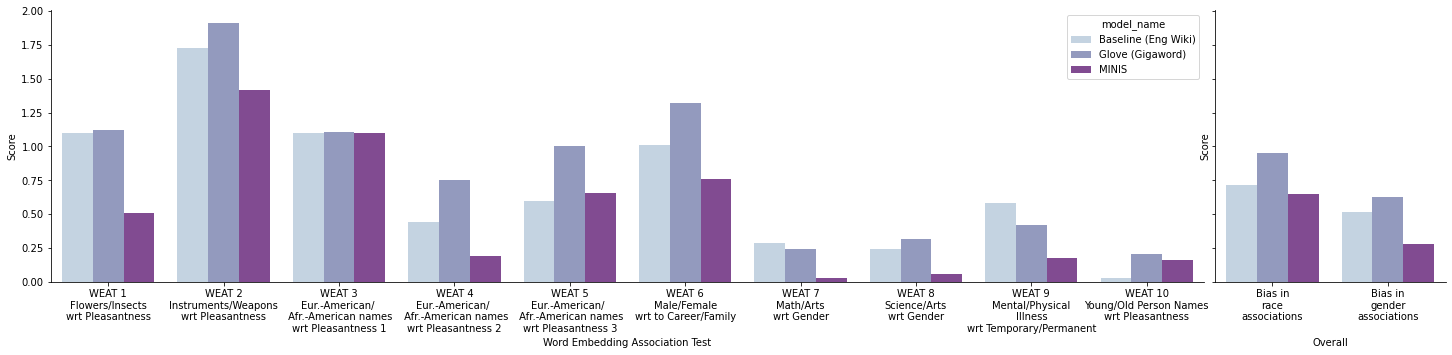

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [5, 1]}, sharey=True)
sns.barplot(data=data, x='Test', y='Score', hue='model_name', ax=ax1, palette="BuPu") #for BW, BuPu is a pallet with monotonically increassing values
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, rotation_mode='anchor') #), ha="right")

summary = pd.DataFrame({"Bias in\nrace\nassociations\n": results.iloc[:,2:5].mean(axis=1),
 "Bias in\ngender\nassociations": results.iloc[:, 5:8].mean(axis=1)
}) #end line breaks to match the horizontal size of the other tick labels
summary_data = summary.reset_index().melt(id_vars='model_name', var_name="Test", value_name="Score")
sns.barplot(data=summary_data, x='Test', y='Score', hue='model_name', ax=ax2, palette="BuPu")

sns.despine(fig)
ax1.set_xlabel('Word Embedding Association Test')
ax2.get_legend().remove()
ax2.set_xlabel('Overall')
plt.subplots_adjust(wspace=0.015)
#handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

### Load MOTES pilot data.

This requires reshaping the data into the format that OpenScoring wants.

<--- The Excel spreadsheet needs to be uploaded to `Files` tab on the left. I grab the 2021 version of the [`MOTES Cognitive Pilot`](https://myunt.sharepoint.com/:x:/r/sites/MOTES819/Shared%20Documents/MOTES%20Cognitive%20Pilot/MOTES%20Cognitive%20Pilot%20Data/MOTES%20Cognitive%20Pilot%20Data.xlsx?d=w256eeb9ac9ce48c8b1cca088d30af687&csf=1&web=1&e=MduIsR) file, alphabetically, so if you upload a file called `./MOTES Cognitive Pilot Data (1).xlsx`, it'll still load :)

In [ ]:
import glob
fpath = glob.glob('./MOTES Cognitive Pilot*xlsx')[-1]
original = pd.read_excel(fpath, sheet_name='Main Data')

In [ ]:
print("Number of participants is", len(original.ID.unique()))

Number of participants is 35


In [ ]:
#@title Load prompts
#@markdown Note that the 'prompt' is actually just the *label* for the question. We want an actual GloVe seed word.
include_alt_prompts = True #@param {type:'boolean'}
prompt_ref = pd.read_excel(fpath, sheet_name='Prompts')
prompt_ref = prompt_ref.melt(id_vars=['question', 'label']).rename(columns={'label':'task', 'value':'prompt'}).dropna()
prompt_ref['alternative'] = prompt_ref.variable != 'prompt'
prompt_ref = prompt_ref.drop(columns=['variable']).sort_values(['task', 'alternative'])
prompt_ref.prompt = prompt_ref.prompt.str.strip()
prompt_ref.task = prompt_ref.task.str.lower()

#@markdown Some of our tested prompts don't exist in the vocabulary, or are all stoplisted words. Drop these.
drop_prompts = ['go back', 'call', 'phonecall', 'texted', 'messaged'] #@param {type:"raw"}
prompt_ref = prompt_ref[~prompt_ref.prompt.isin(drop_prompts)]

if not include_alt_prompts:
    prompt_ref = prompt_ref[~prompt_ref.alternative]
prompt_ref.sample(3)

,question,task,prompt,alternative
107,What would happen if ALIENS LANDED AT YOUR SCH...,g3_alienslanded,aliens school,True
20,What would happen if ALIENS LANDED AT YOUR SCH...,g3_alienslanded,aliens landed,False
163,What would happen if PEOPLE COULD TRAVEL THROU...,g3_timetravel,time,True


In [ ]:
print("Number of questions:", len(prompt_ref.task.unique()))

Number of questions: 29


Note regarding evaluation in MOTES Corpus Paper: since Game 4 was eventually dropped, we also drop it from the pilot eval.

In [ ]:
#@title Get Ground Truth Scores
#@markdown Grab the columns with names such as 'G1_ball_scoreD', and reformat it
#@markdown to get the scores from all three raters.
scores = original[['ID'] + [col for col in original.columns if '_score' in col]]
scores = scores.melt(id_vars='ID', var_name='task', value_name='score')
scores[['task', 'rater']] = scores.task.str.split('_score', expand=True)
scores = scores[scores.score > 0]
scores_wide = scores.pivot(index=['ID', 'task'], columns='rater', values='score')
rater_names = scores_wide.columns.tolist()
scores_wide.head(2)

rater               D    K    T
ID   task                      
10KS G1_backpack  4.0  5.0  4.0
     G1_ball      5.0  3.0  5.0

In [ ]:
#@title Process and save aggregated ground truth
#@markdown Aggregate scores, using three approaches: mean, median, and reconstructed z-score.

#@markdown For ground truth reconstructed from z-scores, I set the mean to 4, and use the mean std of the raters (you can also use the raw z-scores, I suppose).

from scipy.stats import zscore

zscores = dict()
for rater_name in rater_names:
    zscores[rater_name] = zscore(scores_wide[rater_name])
scores_wide['zscore_mean'] = pd.DataFrame(zscores).mean(axis=1).values
mean_std = scores_wide[rater_names].std().mean()
scores_wide['GT_zscore'] = scores_wide['zscore_mean']*mean_std + 4

scores_wide['GT_median'] = scores_wide[['D','K','T']].median(axis=1)
scores_wide['GT_mean'] = scores_wide[['D','K','T']].mean(axis=1)
scores_wide['GT_mean_KT'] = scores_wide[['K','T']].mean(axis=1)

output_fname = 'gt_scores.csv' #@param {type:'string'}
output_w_prompt_fname = 'motes_pilot_gt_scores.csv' #@param {type:'string'}

scores_wide2 = scores_wide.reset_index()
scores_wide2.task = scores_wide2.task.str.lower()
scores_wide2 = scores_wide2.merge(prompt_ref.query('alternative == False')[['task', 'question', 'prompt']])

response_ref = original[['ID']+[c for c in original.columns if c.endswith('spell')]]
response_ref = response_ref.melt(id_vars=['ID'],var_name='task', value_name = 'response')
response_ref.task = response_ref.task.str.lower().str.replace('_spell', '')
scores_wide2 = scores_wide2.merge(response_ref, on=['ID', 'task'], how='left')
scores_wide.to_csv(output_fname)
scores_wide2.to_csv(output_w_prompt_fname)
#@markdown Remember to save the CSV to our Teams if you run it - no need to always re-crunch!
scores_wide.sample(3)

,rater,D,K,T,zscore_mean,GT_zscore,GT_median,GT_mean,GT_mean_KT
ID,task,,,,,,,,
24ES,G4_sleepover,4.0,3.0,2.0,-0.949177,2.734291,3.0,3.000000,2.5
11KS,G1_toothbrush,4.0,3.0,5.0,-0.326410,3.564739,4.0,4.000000,4.0
1RG,G4_playground,4.0,4.0,6.0,0.095190,4.126934,4.0,4.666667,5.0


rater,D,K,T
mean,4.122534,4.856698,4.422638
std,0.835504,1.558367,1.606570


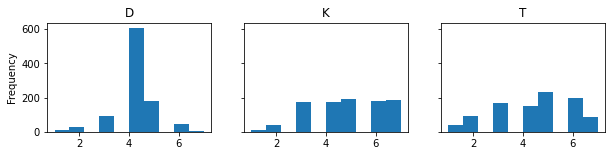

In [ ]:
#@markdown Distributions of raters:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2))
axes = fig.subplots(1, 3, sharey=True)
for i, rater in enumerate(rater_names):
    scores_wide[rater].plot(kind='hist', ax=axes[i], title=rater)
scores_wide[rater_names].aggregate(['mean', 'std'])

## Score spell_corrected data

Grab the columns named '_spell'. Reformat the data to a form accepted by the [`open_scoring`](https://github.com/massivetexts/open-scoring) module.

In [ ]:
spell_tag = "_grammar" #@param ["_spell", "_grammar"]
spell_columns = ['ID'] + [col for col in original.columns if spell_tag in col]
responses = original[spell_columns]
responses.to_csv('responses.csv', index=False)
data = ocs.file.WideData('responses.csv', participant_id='ID')

data.df = data.df.rename(columns={'prompt':'task'})
data.df['task'] = data.df['task'].str.replace(spell_tag, '')
data.df['game'] = data.df.task.str.split('_').apply(lambda x: x[0])

#@markdown Note that the 'prompt' is actually just the *label* for the question. We want an actual GloVe seed word.
include_alt_prompts = True #@param {type:'boolean'}
prompt_ref = pd.read_excel(fpath, sheet_name='Prompts')
prompt_ref = prompt_ref.melt(id_vars=['question', 'label']).rename(columns={'label':'task', 'value':'prompt'}).dropna()
prompt_ref['alternative'] = prompt_ref.variable != 'prompt'
prompt_ref = prompt_ref.drop(columns=['variable']).sort_values(['task', 'alternative'])
prompt_ref.prompt = prompt_ref.prompt.str.strip()
prompt_ref.task = prompt_ref.task.str.lower()

#@markdown Some of our tested prompts don't exist in the vocabulary, or are all stoplisted words. Drop these.
drop_prompts = ['go back', 'call', 'phonecall', 'texted', 'messaged'] #@param {type:"raw"}
prompt_ref = prompt_ref[~prompt_ref.prompt.isin(drop_prompts)]

if not include_alt_prompts:
    prompt_ref = prompt_ref[~prompt_ref.alternative]
data.df = data.df.merge(prompt_ref, how='left', on='task') # Drop_duplicates to only use the first version of a task prompt
data.df.head()

# Test if prompts work
for idx, row in data.df.drop_duplicates('prompt').iterrows():
    try:
        scorer._get_phrase_vecs(row['prompt'], scorer.models[0], True, False)[0].sum(0)
    except:
        print("Error with prompt ", row.prompt)

data.df.sample(3)

,participant,task,response_num,response,game,question,prompt,alternative
2074,34HA,g4_friendcalled,0,my friend called me on the phone to tell me th...,g4,My friend called me on the phone to tell me,text,True
146,11KS,g4_playground,0,met someone's pet monster,g4,"When the friends met in the playground, they",recess,True
2150,3FT,g3_timetravel,0,i would go to the year 1973 and see if my dad ...,g3,What would happen if PEOPLE COULD TRAVEL THROU...,future,True


In [ ]:
data.score_all(scorer, stop=True, idf=True, exclude_target=True)
data.df.sample(3)

Scoring motes


100%|██████████| 2764/2764 [00:13<00:00, 208.37it/s]


Scoring baseline


100%|██████████| 2764/2764 [00:13<00:00, 211.59it/s]


Scoring glove


100%|██████████| 2764/2764 [00:13<00:00, 211.27it/s]


Scoring shows_cooc_raw_09-07_100k


100%|██████████| 2764/2764 [00:13<00:00, 212.50it/s]


Scoring yt_w_en_10-16_100k


100%|██████████| 2764/2764 [00:13<00:00, 212.51it/s]


Scoring books_w_en_100k


100%|██████████| 2764/2764 [00:12<00:00, 215.27it/s]


Scoring simple_wiki_w_en_100k


100%|██████████| 2764/2764 [00:13<00:00, 212.60it/s]


Scoring yt_w_en_100k


100%|██████████| 2764/2764 [00:13<00:00, 198.41it/s]


Scoring show_w_en_100k


100%|██████████| 2764/2764 [00:12<00:00, 214.58it/s]


Scoring all_weighted_10-12_100k


100%|██████████| 2764/2764 [00:12<00:00, 213.80it/s]


Scoring enwiki_full_100k


100%|██████████| 2764/2764 [00:12<00:00, 215.01it/s]


,participant,task,response_num,response,game,question,prompt,alternative,motes_stop_idf,baseline_stop_idf,glove_stop_idf,shows_cooc_raw_09-07_100k_stop_idf,yt_w_en_10-16_100k_stop_idf,books_w_en_100k_stop_idf,simple_wiki_w_en_100k_stop_idf,yt_w_en_100k_stop_idf,show_w_en_100k_stop_idf,all_weighted_10-12_100k_stop_idf,enwiki_full_100k_stop_idf
170,12AM,g1_bottle,0,to make a ship out of a bottle,g1,What would be a surprising use for a BOTTLE?,bottle,False,0.776825,0.733589,0.832378,0.590338,0.747986,0.671240,0.806132,0.840051,0.889110,0.776825,0.733589
44,10KS,g3_timetravel,0,time would not be stable,g3,What would happen if PEOPLE COULD TRAVEL THROU...,time back,True,0.699609,0.684230,0.755523,0.846784,0.733335,0.609287,0.628999,0.782898,0.807067,0.699609,0.684230
778,1RG,g1_toothbrush,0,a cleaning tool for dishes,g1,What would be a surprising use for a TOOTHBRUSH?,toothbrush,False,0.785692,0.937441,0.821929,0.524501,0.743608,0.824880,0.805596,0.847226,0.856585,0.785692,0.937441


# Compare to ground truth

In [ ]:
#@markdown Which version of ground truth to use for validation?
all_gt_cols = [x for x in scores_wide.columns if x.startswith('GT')]
gt_col = "GT_zscore" #@param ["GT_zscore", "GT_mean_KT", "GT_mean", "GT_median"]

#@markdown Which scoring method should be preferred?
preferred_score_col = "motes_stop_idf" #@param {type: 'string' }


In [ ]:
#@markdown ### Overall Correlation
#@markdown 
#@markdown This excludes the alternative prompts
gt = scores_wide[all_gt_cols].reset_index().rename(columns={'ID':'participant'})
gt.task = gt.task.str.lower()
eval_base = data.df[~data.df.alternative].merge(gt)
eval_with_alts = data.df.merge(gt)
eval_base.corr().loc[gt_col, data.scored_columns]

motes_stop_idf                        0.273070
baseline_stop_idf                     0.161201
glove_stop_idf                        0.261249
shows_cooc_raw_09-07_100k_stop_idf    0.139626
yt_w_en_10-16_100k_stop_idf           0.264712
books_w_en_100k_stop_idf              0.205533
simple_wiki_w_en_100k_stop_idf        0.166039
yt_w_en_100k_stop_idf                 0.256882
show_w_en_100k_stop_idf               0.268374
all_weighted_10-12_100k_stop_idf      0.273070
enwiki_full_100k_stop_idf             0.161201
Name: GT_zscore, dtype: float64

In [ ]:
print("Number of participant responses:", eval[['participant', 'task', 'response']].drop_duplicates().shape[0])

Number of participant responses: 963


In [ ]:
#@markdown ### By Task
by_task_with_alts = eval_with_alts.groupby(['task', 'prompt']).corr().round(4).reset_index(2).query(f"level_2 == '{gt_col}'")
by_task_with_alts = by_task_with_alts[data.scored_columns].sort_values(preferred_score_col, ascending=False).reset_index()

by_task_base = eval_base.groupby(['task', 'prompt']).corr().round(4).reset_index(2).query(f"level_2 == '{gt_col}'")
by_task_base = by_task_base[data.scored_columns].sort_values(preferred_score_col, ascending=False).reset_index()
print("No alts:")
for score_col in data.scored_columns:
    print(f"\tMean Task Corr ({score_col})\t", by_task_base.mean().round(3).loc[score_col])

print("Best alts:")
by_task_with_alts['avg_across_tasks'] = by_task_with_alts[data.scored_columns].mean(1)
for score_col in data.scored_columns + ['avg_across_tasks']:
    by_task_best_alts = by_task_with_alts.reset_index().groupby('task', as_index=False).apply(lambda x: x.loc[x[score_col].idxmax()]).sort_values(score_col, ascending=False)
    print(f"\tMean Task Corr ({score_col})\t", by_task_best_alts.mean().round(3).loc[score_col])
# uncomment to base best cols on preferred
#by_task_best_alts = by_task_with_alts.reset_index().groupby('task', as_index=False).apply(lambda x: x.loc[x[preferred_score_col].idxmax()]).sort_values(preferred_score_col, ascending=False)

#@markdown Best prompts are saved for later use as `best_prompts` and `eval_best_prompts`, and a wide output is saved to csv.
best_prompts = by_task_best_alts.prompt.tolist()
eval_best_prompts = eval_with_alts[eval_with_alts.prompt.isin(best_prompts)]

by_task_with_alts.reset_index().sort_values(['task', preferred_score_col], ascending=[True, False]).to_csv('by_task_corr.csv')

No alts:
	Mean Task Corr (motes_stop_idf)	 0.371
	Mean Task Corr (baseline_stop_idf)	 0.282
	Mean Task Corr (glove_stop_idf)	 0.286
	Mean Task Corr (shows_cooc_raw_09-07_100k_stop_idf)	 0.201
	Mean Task Corr (yt_w_en_10-16_100k_stop_idf)	 0.344
	Mean Task Corr (books_w_en_100k_stop_idf)	 0.305
	Mean Task Corr (simple_wiki_w_en_100k_stop_idf)	 0.249
	Mean Task Corr (yt_w_en_100k_stop_idf)	 0.291
	Mean Task Corr (show_w_en_100k_stop_idf)	 0.314
	Mean Task Corr (all_weighted_10-12_100k_stop_idf)	 0.371
	Mean Task Corr (enwiki_full_100k_stop_idf)	 0.282
Best alts:
	Mean Task Corr (motes_stop_idf)	 0.416
	Mean Task Corr (baseline_stop_idf)	 0.339
	Mean Task Corr (glove_stop_idf)	 0.338
	Mean Task Corr (shows_cooc_raw_09-07_100k_stop_idf)	 0.268
	Mean Task Corr (yt_w_en_10-16_100k_stop_idf)	 0.398
	Mean Task Corr (books_w_en_100k_stop_idf)	 0.354
	Mean Task Corr (simple_wiki_w_en_100k_stop_idf)	 0.296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


	Mean Task Corr (yt_w_en_100k_stop_idf)	 0.349
	Mean Task Corr (show_w_en_100k_stop_idf)	 0.374
	Mean Task Corr (all_weighted_10-12_100k_stop_idf)	 0.416
	Mean Task Corr (enwiki_full_100k_stop_idf)	 0.339
	Mean Task Corr (avg_across_tasks)	 0.341


In [ ]:
eval[['game', 'motes_stop_idf', 'baseline_stop_idf']].dropna().shape

(1008, 3)

In [ ]:
#@markdown ### By Game
from scipy.stats import pearsonr
def get_sig(x, col1='target', col2='predicted'):
    return pearsonr(x[col1], x[col2])[1]

for name, eval in [('Base', eval_base), ('best prompt', eval_best_prompts)]:
    by_game = eval.groupby('game').corr().round(4)
    by_game = by_game.reset_index(1).query(f'level_1 == "{gt_col}"')[data.scored_columns]
    for score_col in data.scored_columns:
        print(f"Mean {name} Game Corr ({score_col})", by_game.mean()[score_col].round(4))

print("Using best prompts:")
display(by_game)

# wrong - this is just whether motes is difference from baselines - 
# we want to know if motes correlation with people is significant compared to 
# baseline correlation with people.
#print("Sig of MOTES vs Baseline")
#sig = eval.dropna().groupby('game').apply(lambda x: get_sig(x, col1='motes_stop_idf', col2='baseline_stop_idf'))
#display(sig)
# better: For comparing correlation coefficients, use
# http://comparingcorrelations.org/, and the correlation between motes and baseline is need for 
# this dependent, overlapping corr
eval.dropna().groupby('game')[['motes_stop_idf', 'baseline_stop_idf']].corr().iloc[1::2, 0]

Mean Base Game Corr (motes_stop_idf) 0.2998
Mean Base Game Corr (baseline_stop_idf) 0.1986
Mean Base Game Corr (glove_stop_idf) 0.2564
Mean Base Game Corr (shows_cooc_raw_09-07_100k_stop_idf) 0.1802
Mean Base Game Corr (yt_w_en_10-16_100k_stop_idf) 0.264
Mean Base Game Corr (books_w_en_100k_stop_idf) 0.216
Mean Base Game Corr (simple_wiki_w_en_100k_stop_idf) 0.1736
Mean Base Game Corr (yt_w_en_100k_stop_idf) 0.2564
Mean Base Game Corr (show_w_en_100k_stop_idf) 0.2695
Mean Base Game Corr (all_weighted_10-12_100k_stop_idf) 0.2998
Mean Base Game Corr (enwiki_full_100k_stop_idf) 0.1986
Mean best prompt Game Corr (motes_stop_idf) 0.3613
Mean best prompt Game Corr (baseline_stop_idf) 0.2507
Mean best prompt Game Corr (glove_stop_idf) 0.3152
Mean best prompt Game Corr (shows_cooc_raw_09-07_100k_stop_idf) 0.1732
Mean best prompt Game Corr (yt_w_en_10-16_100k_stop_idf) 0.3562
Mean best prompt Game Corr (books_w_en_100k_stop_idf) 0.2682
Mean best prompt Game Corr (simple_wiki_w_en_100k_stop_idf)

,motes_stop_idf,baseline_stop_idf,glove_stop_idf,shows_cooc_raw_09-07_100k_stop_idf,yt_w_en_10-16_100k_stop_idf,books_w_en_100k_stop_idf,simple_wiki_w_en_100k_stop_idf,yt_w_en_100k_stop_idf,show_w_en_100k_stop_idf,all_weighted_10-12_100k_stop_idf,enwiki_full_100k_stop_idf
game,,,,,,,,,,,
g1,0.3881,0.2068,0.2651,0.1724,0.3408,0.2659,0.3176,0.3171,0.3077,0.3881,0.2068
g2,0.4268,0.3153,0.4643,0.2800,0.4829,0.3104,0.1777,0.4394,0.4577,0.4268,0.3153
g3,0.4304,0.2625,0.3296,0.2289,0.3891,0.2865,0.3007,0.3978,0.4320,0.4304,0.2625
g4,0.2000,0.2184,0.2016,0.0113,0.2120,0.2102,0.1993,0.0993,0.1067,0.2000,0.2184


game                   
g1    baseline_stop_idf    0.700977
g2    baseline_stop_idf    0.718079
g3    baseline_stop_idf    0.824364
g4    baseline_stop_idf    0.813612
Name: motes_stop_idf, dtype: float64

In [ ]:
eval.dropna().groupby('game')[['books_w_en_100k_stop_idf', 'baseline_stop_idf']].corr().iloc[1::2, 0]

game                   
g1    baseline_stop_idf    0.758615
g2    baseline_stop_idf    0.671468
g3    baseline_stop_idf    0.822724
g4    baseline_stop_idf    0.756222
Name: books_w_en_100k_stop_idf, dtype: float64

This shows that MOTES corpus (build on en wiki) greatly outperforms the enwiki-only baseline, though it could be improved by being built on a stronger foundation (e.g. recreating glove 6b).

In [ ]:
#@markdown By Participant
for name, eval in [('Base', eval_base), ('Best', eval_best_prompts)]:
    print(name.upper().center(10,'-'))
    by_person = eval.groupby(data.id_cols).corr().round(4)
    by_person = by_person.reset_index(1).query(f'level_1 == "{gt_col}"')[data.scored_columns].sort_values(data.scored_columns, ascending=False)
    for score_col in data.scored_columns:
        print(f"Mean Participant Corr ({score_col}))", by_person[[score_col]].mean().iloc[0])

,prompt,response,baseline_stop,motes_stop,model_diff
453,tasty,noodles,0.547917,0.786388,0.238471
181,toothbrush,to clean the sink,0.933704,0.695710,0.237994
971,time back future,i would see dinos,1.032909,0.799274,0.233635
2002,sleepover,with a moose,1.053672,0.828144,0.225528
1255,sleepover,resurrect the dinosaurs,1.141802,0.919062,0.222740
15,toothbrush,you can take off the top and make it a spoon,0.958311,0.738066,0.220244
446,toothbrush,it can be used to brush your hair instead if y...,0.951598,0.741220,0.210378
612,toothbrush,to clean the bathroom with,0.909319,0.699175,0.210144
347,toothbrush,you can use the toothbrush and sing with it,0.970700,0.765152,0.205548
703,wet,an eyeball,0.935764,0.730541,0.205223


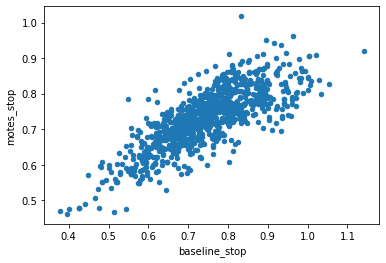

In [ ]:
#@title Biggest differences between default GloVe and MOTES (for best prompts)
data.df[data.df.prompt.isin(best_prompts)].plot(x='baseline_stop', y='motes_stop', kind='scatter')

data.df['model_diff'] = (data.df['baseline_stop'] - data.df['motes_stop']).abs()
data.df[data.df.prompt.isin(best_prompts)].sort_values('model_diff', ascending=False).dropna()[['prompt', 'response', 'baseline_stop', 'motes_stop', 'model_diff']].head(10)

## Run on an Adult Dataset

In [ ]:
!wget -q -O dod20.csv https://osf.io/download/u3yv4/

src = 'dod20'
paca = pd.read_csv('dod20.csv', index_col=0)
paca = paca[~paca.response.str.contains('!!!')]
paca['target'] = paca[['rater1', 'rater2', 'rater3', 'rater4']].mean(1)
paca.sample()

,participant,prompt,response_num,original_response,response,rater1,rater2,rater3,rater4,human_vote,...,word2vec_idf,tasa_lsa,en100_lsa,glove,tasa_lsa_idf,en100_lsa_idf,word2vec,elmo,elmo_idf,target
4083,59,brick,5,downspout diverter,downspout diverter,2.0,2.0,5.0,3.0,3.0,...,0.814438,1.096312,NaN,0.870932,1.096312,NaN,0.787177,0.451078,0.433123,3.0


In [ ]:
for model in scorer.models:
    paca[model] = paca.apply(lambda x: scorer.originality(x['prompt'], x['response'], model=model, stopword=True, term_weighting=True), axis=1)


In [ ]:
paca.corr()['target'][scorer.models]

motes       0.371934
baseline    0.373648
glove       0.411947
Name: target, dtype: float64